In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\trupt\Downloads\Auto_Insurance_Fraud_Claims_File01.csv")
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_summary = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
print("\n🔍 Missing Value Summary:")
print(missing_summary[missing_summary['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False))
duplicate_count = df.duplicated().sum()
print(f"\n🔁 Duplicate Rows: {duplicate_count}")
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = len(outliers)

outliers_df = pd.DataFrame.from_dict(outlier_counts, orient='index', columns=['Outlier Count'])
outliers_df = outliers_df[outliers_df['Outlier Count'] > 0].sort_values(by='Outlier Count', ascending=False)
print("\n📊 Outlier Summary (Top 10 columns):")
print(outliers_df.head(10))



🔍 Missing Value Summary:
                       Missing Count  Missing %
Police_Report                  13716      34.29
authorities_contacted           3600       9.00

🔁 Duplicate Rows: 0

📊 Outlier Summary (Top 10 columns):
                      Outlier Count
Umbrella_Limit                 8040
Low_Mileage_Discount           7624
Vehicle_Claim                  1740
Property_Claim                 1738
Injury_Claim                   1719
Vehicle_Cost                    925
Commute_Discount                783
Total_Claim                     675
Policy_Premium                  365
Age_Insured                     165


In [2]:
# Step 1: Load all three datasets
train_df = pd.read_csv(r"C:\Users\trupt\Downloads\Auto_Insurance_Fraud_Claims_File01.csv")
val_df   = pd.read_csv(r"C:\Users\trupt\Downloads\Auto_Insurance_Fraud_Claims_File02.csv")
test_df  = pd.read_csv(r"C:\Users\trupt\Downloads\Auto_Insurance_Fraud_Claims_File03.csv")  

# Step 2: Replace missing values with "Unknown" in all datasets
for df in [train_df, val_df, test_df]:
    for col in ['Police_Report', 'authorities_contacted']:
        if col in df.columns:
            df[col] = df[col].fillna("Unknown")

In [3]:
# Separate numerical and categorical columns
cat_cols = train_df.select_dtypes(include='object').columns.tolist()
num_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [4]:
print("Categorical Columns:",cat_cols)
print("Numerical Columns:",num_cols)


Categorical Columns: ['Claim_ID', 'Bind_Date1', 'Policy_State', 'Policy_Start_Date', 'Policy_Expiry_Date', 'Policy_BI', 'Gender', 'Education', 'Occupation', 'Hobbies', 'Insured_Relationship', 'Garage_Location', 'Accident_Date', 'Accident_Type', 'Collision_Type', 'Accident_Severity', 'authorities_contacted', 'Acccident_State', 'Acccident_City', 'Accident_Location', 'Property_Damage', 'Police_Report', 'DL_Expiry_Date', 'Claims_Date', 'Auto_Make', 'Auto_Model', 'Vehicle_Color', 'Fraud_Ind', 'Vehicle_Registration', 'Check_Point']
Numerical Columns: ['Customer_Life_Value1', 'Age_Insured', 'Policy_Num', 'Policy_Ded', 'Policy_Premium', 'Umbrella_Limit', 'Insured_Zip', 'Capital_Gains', 'Capital_Loss', 'Accident_Hour', 'Num_of_Vehicles_Involved', 'Bodily_Injuries', 'Witnesses', 'Auto_Year', 'Vehicle_Cost', 'Annual_Mileage', 'DiffIN_Mileage', 'Low_Mileage_Discount', 'Commute_Discount', 'Total_Claim', 'Injury_Claim', 'Property_Claim', 'Vehicle_Claim']


In [5]:
target_col = 'Fraud_Ind'

# Find object columns
cat_cols = train_df.select_dtypes(include='object').columns.tolist()

# Exclude the target column from categorical features
if target_col in cat_cols:
    cat_cols.remove(target_col)

print("Final categorical columns:",cat_cols)

Final categorical columns: ['Claim_ID', 'Bind_Date1', 'Policy_State', 'Policy_Start_Date', 'Policy_Expiry_Date', 'Policy_BI', 'Gender', 'Education', 'Occupation', 'Hobbies', 'Insured_Relationship', 'Garage_Location', 'Accident_Date', 'Accident_Type', 'Collision_Type', 'Accident_Severity', 'authorities_contacted', 'Acccident_State', 'Acccident_City', 'Accident_Location', 'Property_Damage', 'Police_Report', 'DL_Expiry_Date', 'Claims_Date', 'Auto_Make', 'Auto_Model', 'Vehicle_Color', 'Vehicle_Registration', 'Check_Point']


In [6]:
from sklearn.preprocessing import LabelEncoder
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([train_df[col], val_df[col], test_df[col]]).astype(str).unique()
    le.fit(all_values)
    train_df[col] = le.transform(train_df[col].astype(str))
    val_df[col]   = le.transform(val_df[col].astype(str))
    test_df[col]  = le.transform(test_df[col].astype(str))

    encoders[col]= le

In [7]:
date_cols = ['Accident_Date', 'Claims_Date']

for df in [train_df, val_df, test_df]:
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce',dayfirst=True)

In [8]:
for df in [train_df, val_df, test_df]:
    # 1. Claim duration in days
    df['Claim_Duration_Days'] = (df['Claims_Date'] - df['Accident_Date']).dt.days

    # 2. Claim amount per injury 
    df['Claim_Amount_per_Injury'] = df["Total_Claim"] / (df['Injury_Claim'] + 1)

    # 3. Weekend accident
    df['Is_Weekend_Accident'] = df['Accident_Date'].dt.weekday.isin([5, 6]).astype(int)

    # 4. Police contacted flag
    df['Police_Contacted_Flag'] = (df['Police_Report'] != 'Unknown').astype(int)

    # 5. Total damage score (if applicable)
    df['Total_Damage_Score'] = df['Injury_Claim'] + df['Property_Claim'] + df['Vehicle_Claim']

In [9]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [10]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    matthews_corrcoef
)

# === Step 1: Define label column ===
label_col = 'Fraud_Ind'

# === Step 2: Split data into features and target ===
X_train = train_df.drop(columns=[label_col])
y_train = train_df[label_col]

X_val = val_df.drop(columns=[label_col])
y_val = val_df[label_col]

# === Handle test_df if it doesn't have label ===
if label_col in test_df.columns:
    X_test = test_df.drop(columns=[label_col])
    y_test = test_df[label_col]
else:
    X_test = test_df.copy()
    y_test = None  # unknown during testing

# === Step 3: Drop datetime columns ===
datetime_cols = X_train.select_dtypes(include='datetime64').columns
X_train = X_train.drop(columns=datetime_cols)
X_val = X_val.drop(columns=datetime_cols)
X_test = X_test.drop(columns=datetime_cols)

# === Step 4: Standardize numeric features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# === Step 5: Train models ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from lightgbm import LGBMClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(),
    'Bagging': BaggingClassifier(),
    'LightGBM': LGBMClassifier()
}

val_scores = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, preds)
    val_scores[name] = acc
    print(f"{name}: Accuracy = {acc:.4f}")

# === Step 6: Choose best model ===
best_model_name = max(val_scores, key=val_scores.get)
best_model = models[best_model_name]
print(f"\n✅ Best model: {best_model_name}")

# === Step 7: Evaluate on test set (if labels exist) ===
if y_test is not None:
    y_test_preds = best_model.predict(X_test_scaled)
    y_test_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_test_preds)
    precision = precision_score(y_test, y_test_preds)
    recall = recall_score(y_test, y_test_preds)
    f1 = f1_score(y_test, y_test_preds)
    mcc = matthews_corrcoef(y_test, y_test_preds)
    roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    cm = confusion_matrix(y_test, y_test_preds)
    report = classification_report(y_test, y_test_preds)

    print("\n📊 Test Set Evaluation:")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1:.4f}")
    print(f"Matthews Corr. : {mcc:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC        : {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
else:
    print("\n⚠ Test set has no labels. Skipping evaluation.")


Logistic Regression: Accuracy = 0.7863
Random Forest: Accuracy = 1.0000
Gradient Boosting: Accuracy = 0.9404
Decision Tree: Accuracy = 1.0000
KNN: Accuracy = 0.9968
Naive Bayes: Accuracy = 0.7512
AdaBoost: Accuracy = 0.8718
Bagging: Accuracy = 1.0000
[LightGBM] [Info] Number of positive: 9880, number of negative: 30120
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5029
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.247000 -> initscore=-1.114677
[LightGBM] [Info] Start training from score -1.114677
LightGBM: Accuracy = 1.0000

✅ Best model: Random Forest

⚠ Test set has no labels. Skipping evaluation.


In [13]:
!pip install matplotlib seaborn


Defaulting to user installation because normal site-packages is not writeable


In [25]:
print(type(y_test))



<class 'NoneType'>


In [26]:
y_val_binary = y_val.map({'Y':1, 'N':0})


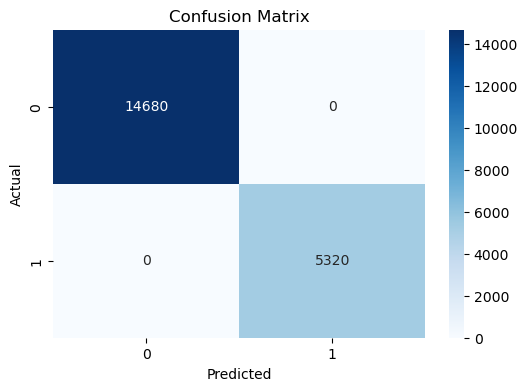

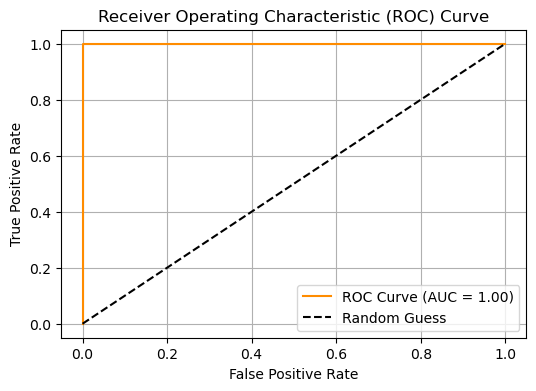

Classification Report:

              precision    recall  f1-score   support

           N       1.00      1.00      1.00     14680
           Y       1.00      1.00      1.00      5320

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Convert 'Y'/'N' to binary: 1/0
y_val_binary = y_val.map({'Y': 1, 'N': 0})

#Predict probabilities and classes
y_val_probs = best_model.predict_proba(X_val_scaled)[:, 1]
y_val_preds = best_model.predict(X_val_scaled)

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_val_binary, y_val_probs)
roc_auc = roc_auc_score(y_val_binary, y_val_probs)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 3. Classification Report
print("Classification Report:\n")
print(classification_report(y_val, y_val_preds))


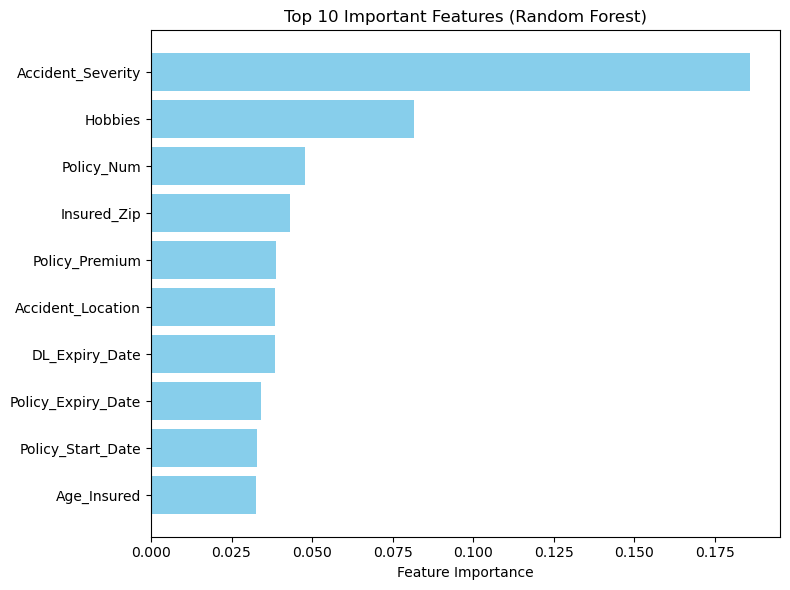

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns  # Use the correct feature set you trained with

# Create DataFrame and sort
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features (Random Forest)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [36]:
df['Claim_to_Premium_Ratio'] = df['Total_Claim'] / (df['Policy_Premium'] + 1e-6)


In [37]:
df.head()


,Claim_ID,Bind_Date1,Customer_Life_Value1,Age_Insured,Policy_Num,Policy_State,Policy_Start_Date,Policy_Expiry_Date,Policy_BI,Policy_Ded,...,Property_Claim,Vehicle_Claim,Vehicle_Registration,Check_Point,Claim_Duration_Days,Claim_Amount_per_Injury,Is_Weekend_Accident,Police_Contacted_Flag,Total_Damage_Score,Claim_to_Premium_Ratio
0,60000,6,22,31,116375016,1,24,82,2,500,...,4153.83,4675.45,57121,0,-1,8.236295,0,1,10048.28,14.179668
1,60001,12,16,34,189560103,0,13,71,0,2000,...,1043.39,5645.08,14712,0,0,2.118181,0,1,12668.14,11.976271
2,60002,2,15,27,197359502,0,12,70,0,1000,...,82.28,347.94,57234,0,0,2.149030,0,1,802.77,0.579822
3,60003,0,24,28,123790687,2,4,62,2,1000,...,5908.36,3611.06,45587,0,0,6.292716,0,1,11316.82,11.471339
4,60004,7,21,42,145901048,0,83,28,0,500,...,8650.96,1200.47,4365,0,0,3.956578,0,1,13182.13,10.019252
